In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy.integrate as integrate
from scipy.linalg import ishermitian, expm
from functools import reduce
from multiprocessing import Pool, cpu_count
import pandas as pd
import timeit
import time

In [2]:
w1 = 0.1
w2 = (1+np.sqrt(5))*w1/2
latsize = 1
phi1 = np.pi/10
phi2 = 0
m = 1.5
eta = 2

In [3]:
sigmax = np.matrix([[0, 1],[1, 0]], dtype=complex)
sigmay = np.matrix([[0, -1j],[1j, 0]], dtype=complex)
sigmaz = np.matrix([[1, 0j],[0, -1]], dtype=complex)

def temporalBHZham(w1, phi1, w2, phi2, m, t):
    return (np.sin(w1*t+phi1)*sigmax + np.sin(w2*t+phi2)*sigmay + (m - np.cos(w1*t+phi1) - np.cos(w2*t+phi2))*sigmaz)

def dh1t(w1, phi1, t):
    return w1*(np.sin(w1*t+phi1)*sigmaz + np.cos(w1*t+phi1)*sigmax)

def dh2t(w2, phi2, t):
    return w2*(np.sin(w2*t+phi2)*sigmaz + np.cos(w2*t+phi2)*sigmay)

Evolution

In [4]:
def U(w1, phi1, w2, phi2, m, T, dt):
    tvals = np.arange(0, T+dt, dt)
    u = np.identity(2, dtype=complex)
    for i in tvals:
        u = expm(-1j*dt*temporalBHZham(w1, phi1, w2, phi2, m, i)) @ u
    return np.matrix(u)

In [5]:
 def work1(w1, phi1, w2, phi2, m, T, dt, step):
    psi0 = np.matrix(np.array([ 0.95523994+0.j,  0.29583214+0.j]).reshape(2,1))
    w_op = lambda s: psi0.H@ U(w1, phi1, w2, phi2, m, s, dt).H @ dh1t(w1, phi1, s) @ U(w1, phi1, w2, phi2, m, s, dt) @psi0
    tvals = np.arange(0, T, step)
    samples = [w_op(i).item() for i in tvals]
    res = integrate.simpson(samples, tvals)
    return res
    

In [6]:
def w1_op(args):
    w1, phi1, w2, phi2, m, dt, s = args
    psi0 = np.array([0.95523994+0.j, 0.29583214+0.j]).reshape(2,1)
    return (
        psi0.conj().T
        @ U(w1, phi1, w2, phi2, m, s, dt).conj().T
        @ dh1t(w1, phi1, s)
        @ U(w1, phi1, w2, phi2, m, s, dt)
        @ psi0
    ).item()

def work1(w1, phi1, w2, phi2, m, Ti, Tf, dt, step):
    tvals = np.linspace(Ti, Tf, int((Tf-Ti)/step)+1)

    # pack parameters into tuples for each s
    args_list = [(w1, phi1, w2, phi2, m, dt, s) for s in tvals]

    with Pool(processes=cpu_count()) as pool:
        samples = pool.map(w1_op, args_list)

    res = integrate.simpson(samples, tvals)
    return res

def w2_op(args):
    w1, phi1, w2, phi2, m, dt, s = args
    psi0 = np.array([0.95523994+0.j, 0.29583214+0.j]).reshape(2,1)
    return (
        psi0.conj().T
        @ U(w1, phi1, w2, phi2, m, s, dt).conj().T
        @ dh2t(w2, phi2, s)
        @ U(w1, phi1, w2, phi2, m, s, dt)
        @ psi0
    ).item()

def work2(w1, phi1, w2, phi2, m, Ti, Tf, dt, step):
    tvals = np.linspace(Ti, Tf, int((Tf-Ti)/step)+1)

    # pack parameters into tuples for each s
    args_list = [(w1, phi1, w2, phi2, m, dt, s) for s in tvals]

    with Pool(processes=cpu_count()) as pool:
        samples = pool.map(w2_op, args_list)

    res = integrate.simpson(samples, tvals)
    return res

In [9]:
work2(w1, phi1, w2, phi2, m, 0,1, 0.1, 0.01) + work2(w1, phi1, w2, phi2, m, 1,2, 0.1, 0.01) + work2(w1, phi1, w2, phi2, m, 2,4, 0.1, 0.01)

(-0.26098614483448923-7.547492723395738e-18j)

In [12]:
start = time.perf_counter()

cycles = 30
T = 2*np.pi*cycles/w1
worktime = np.arange(0,T,0.1)
dt = 0.1
step = 0.01

drive1 = [work1(w1, phi2, w2, phi2, m, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
drive2 = [work2(w1, phi2, w2, phi2, m, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
end = time.perf_counter()
print(end - start, seconds)

NameError: name 'seconds' is not defined

In [15]:
print((end - start)/(60*60), 'hours')

9.529733227842225 seconds


In [16]:
drive1_t = [np.sum(drive1[:i]) for i in range(len(drive1))]
drive2_t = [np.sum(drive2[:i]) for i in range(len(drive1))]

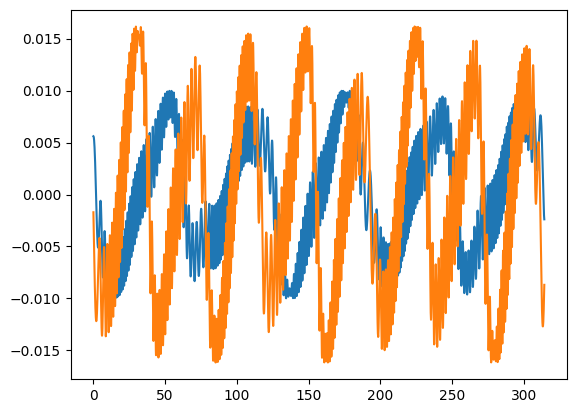

In [72]:
plt.plot(worktime[1:],np.real(drive1))
plt.plot(worktime[1:],np.real(drive2))
plt.show()

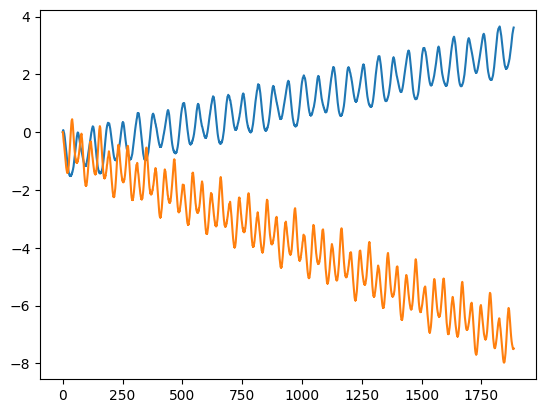

In [19]:
plt.plot(worktime[1:],np.real(drive1_t))
plt.plot(worktime[1:],np.real(drive2_t))

plt.show()

In [23]:
np.savetxt('drive1_work.txt', drive1_t, delimiter=',')
np.savetxt('drive2_work.txt', drive2_t, delimiter=',')

In [15]:
drive1_t = np.real(np.loadtxt('plotData/drive1_work.txt', dtype=complex))
drive2_t = np.real(np.loadtxt('plotData/drive2_work.txt', dtype=complex))

In [18]:
cycles = 30
T = 2*np.pi*cycles/w1
worktime = np.arange(0,T,0.1)
len(drive1_t)

18849

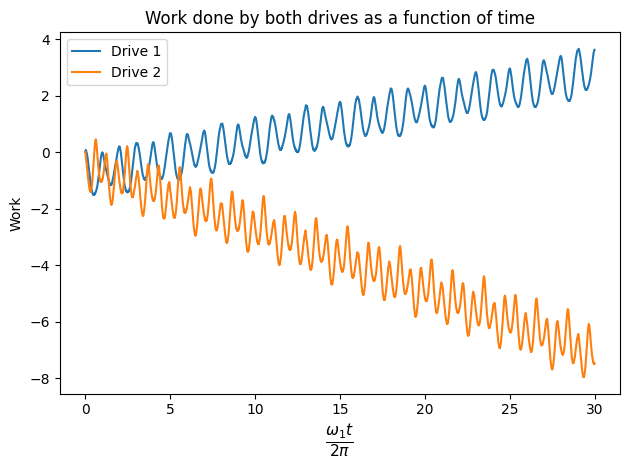

In [38]:
plt.plot(worktime[1:]*w1/(2*np.pi), drive1_t)
plt.plot(worktime[1:]*w1/(2*np.pi), drive2_t)
plt.legend(['Drive 1', 'Drive 2'])
plt.xlabel(r'$\frac{\omega_1 t}{2\pi}$', fontsize=16)
plt.ylabel('Work')
plt.title('Work done by both drives as a function of time')
plt.tight_layout()
plt.savefig('workdone.png', dpi=500)